# Dataset ARE

In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [2]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('ARE-Historical-Data-2015.csv')
df1=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 [==============================] - 5s 93ms/step - loss: 0.0952 - val_loss: 0.0515
Epoch 2/100
22/22 [==============================] - 1s 61ms/step - loss: 0.0081 - val_loss: 0.0141
Epoch 3/100
22/22 [==============================] - 1s 60ms/step - loss: 0.0041 - val_loss: 0.0152
Epoch 4/100
22/22 [==============================] - 1s 64ms/step - loss: 0.0029 - val_loss: 0.0108
Epoch 5/100
22/22 [==============================] - 1s 61ms/step - loss: 0.0020 - val_loss: 0.0064
Epoch 6/100
22/22 [==============================] - 1s 61ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 7/100
22/22 [==============================] - 2s 96ms/step - loss: 8.4136e-04 - val_loss: 0.0018
Epoch 8/100
22/22 [==============================] - 2s 76ms/step - loss: 6.0587e-04 - val_loss: 7.3542e-04
Epoch 9/100
22/22 [==============================] - 1s 62ms/step - loss: 5.2656e-04 - val_loss: 4.5218e-04
Epoch 10/100
22/22 [==============================] - 1s 63ms/step - loss: 4.994

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

4/4 [==============================] - 0s 11ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 95.45116435940164
Testing RMSE: 100.02165565881273


In [13]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps= 152
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.13684834 0.13500527 0.13796735 0.13540021 0.13757241 0.14290416
 0.14836756 0.13862559 0.13790153 0.14441811 0.13816482 0.13816482
 0.13730911 0.13309637 0.14132438 0.13500527 0.13414955 0.13276725
 0.13665087 0.13052923 0.12921274 0.12644813 0.12506582 0.12131385
 0.12723802 0.12743549 0.11907583 0.11328331 0.1135466  0.10406793
 0.10327804 0.11203265 0.11367825 0.12203791 0.13145076 0.13724329
 0.14204845 0.14250922 0.13855977 0.13283307 0.1288178  0.12875197
 0.13329384 0.12269616 0.12012902 0.12486835 0.12065561 0.13151659
 0.13052923 0.1400079  0.14448394 0.13875724 0.14994734 0.15027646
 0.14270669 0.14369405 0.14540548 0.15126382 0.15060558 0.15060558
 0.14915745 0.14257504 0.13000263 0.13816482 0.13066087 0.14487888
 0.13368878 0.12414429 0.1269089  0.14244339 0.14303581 0.1364534
 0.1342812  0.14685361 0.14454976 0.14882833 0.14718273 0.14408899
 0.14566877 0.14060032 0.1397446  0.14158768 0.14125856 0.14435229
 0.14988152 0.15376514 0.14889415 0.16100579 0.1586

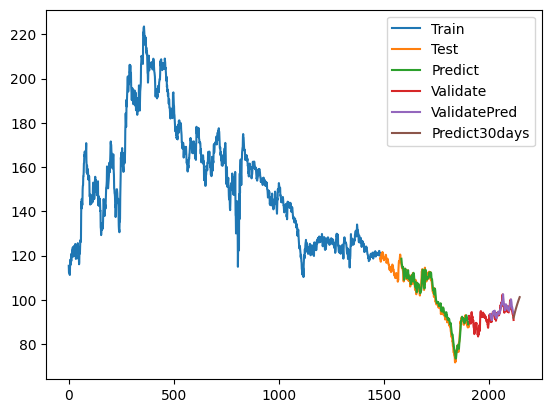

In [14]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [15]:
scaler.inverse_transform(lst_output)

array([[ 91.93184442],
       [ 92.20276508],
       [ 92.59203866],
       [ 92.9927036 ],
       [ 93.38787886],
       [ 93.77518068],
       [ 94.15431476],
       [ 94.5253943 ],
       [ 94.88867963],
       [ 95.24446052],
       [ 95.59309011],
       [ 95.93488307],
       [ 96.2701586 ],
       [ 96.59920645],
       [ 96.92232545],
       [ 97.23976689],
       [ 97.55176845],
       [ 97.85856556],
       [ 98.16034161],
       [ 98.45729579],
       [ 98.7495979 ],
       [ 99.03739734],
       [ 99.32085484],
       [ 99.60008812],
       [ 99.87522848],
       [100.14638684],
       [100.41368997],
       [100.67721032],
       [100.93705429],
       [101.19331468]])

# Dataset ARI

In [16]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('ARI-Historical-Data-2015.csv')
df1=df.reset_index()['Price']

In [17]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [18]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [19]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [20]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [21]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [22]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 [==============================] - 5s 126ms/step - loss: 0.1120 - val_loss: 0.0181
Epoch 2/100
22/22 [==============================] - 1s 63ms/step - loss: 0.0088 - val_loss: 0.0022
Epoch 3/100
22/22 [==============================] - 1s 59ms/step - loss: 0.0043 - val_loss: 4.0919e-04
Epoch 4/100
22/22 [==============================] - 1s 59ms/step - loss: 0.0030 - val_loss: 2.7997e-04
Epoch 5/100
22/22 [==============================] - 1s 61ms/step - loss: 0.0021 - val_loss: 2.6137e-04
Epoch 6/100
22/22 [==============================] - 1s 59ms/step - loss: 0.0015 - val_loss: 2.5359e-04
Epoch 7/100
22/22 [==============================] - 1s 59ms/step - loss: 0.0011 - val_loss: 2.4781e-04
Epoch 8/100
22/22 [==============================] - 1s 59ms/step - loss: 8.3799e-04 - val_loss: 2.5439e-04
Epoch 9/100
22/22 [==============================] - 2s 100ms/step - loss: 7.4523e-04 - val_loss: 2.3818e-04
Epoch 10/100
22/22 [==============================] - 2s 81ms/

In [24]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

4/4 [==============================] - 0s 11ms/step


In [25]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [26]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 16.154479039281096
Testing RMSE: 15.741487405456208


In [27]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps= 152
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.83419689 0.82189119 0.81735751 0.81800518 0.81800518 0.82124352
 0.81994819 0.81865285 0.81282383 0.80310881 0.7888601  0.78756477
 0.78173575 0.79339378 0.81023316 0.80829016 0.81800518 0.8257772
 0.82512953 0.82772021 0.82836788 0.81994819 0.81994819 0.80634715
 0.81217617 0.81541451 0.81930052 0.79857513 0.80634715 0.78950777
 0.79274611 0.8134715  0.8503886  0.8503886  0.85556995 0.85751295
 0.8626943  0.84909326 0.84391192 0.83678756 0.82836788 0.83160622
 0.83290155 0.8257772  0.82318653 0.82707254 0.82966321 0.83743523
 0.84067358 0.85168394 0.8503886  0.83743523 0.84909326 0.8484456
 0.83354922 0.83937824 0.84196891 0.84650259 0.84909326 0.85168394
 0.85297927 0.84520725 0.82966321 0.83095855 0.82901554 0.83031088
 0.8257772  0.82642487 0.83743523 0.8380829  0.83678756 0.83225389
 0.83290155 0.84391192 0.84132124 0.84455959 0.84002591 0.82966321
 0.83290155 0.83225389 0.83290155 0.83290155 0.83678756 0.84455959
 0.84261658 0.84067358 0.8361399  0.84585492 0.84067

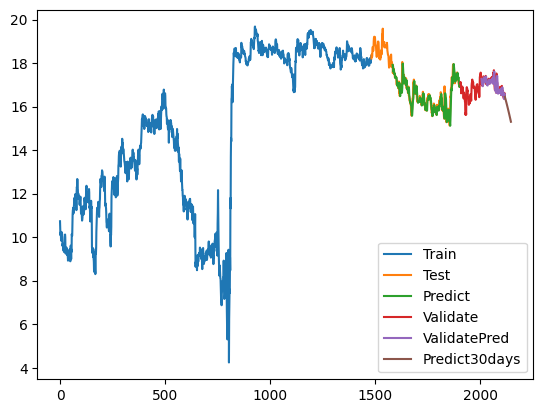

In [28]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [29]:
scaler.inverse_transform(lst_output)

array([[16.4484543 ],
       [16.41648139],
       [16.38096809],
       [16.34496521],
       [16.30866322],
       [16.27203269],
       [16.23506625],
       [16.19775194],
       [16.16008976],
       [16.12207971],
       [16.08372546],
       [16.04503163],
       [16.00600281],
       [15.966639  ],
       [15.92694572],
       [15.88694323],
       [15.84663704],
       [15.80603911],
       [15.76516602],
       [15.7240242 ],
       [15.68263574],
       [15.64101813],
       [15.59917596],
       [15.55713317],
       [15.51489436],
       [15.47247425],
       [15.42989033],
       [15.38716468],
       [15.34429914],
       [15.30131673]])

# Dataset MAA

In [30]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('MAA-Historical-Data-2015.csv')
df1=df.reset_index()['Price']

In [31]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [32]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [33]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [34]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [35]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [36]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [37]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 [==============================] - 5s 81ms/step - loss: 0.0585 - val_loss: 0.0280
Epoch 2/100
22/22 [==============================] - 1s 63ms/step - loss: 0.0074 - val_loss: 0.0051
Epoch 3/100
22/22 [==============================] - 1s 61ms/step - loss: 0.0021 - val_loss: 7.6281e-04
Epoch 4/100
22/22 [==============================] - 1s 61ms/step - loss: 5.7959e-04 - val_loss: 1.6023e-04
Epoch 5/100
22/22 [==============================] - 1s 61ms/step - loss: 4.5099e-04 - val_loss: 1.6281e-04
Epoch 6/100
22/22 [==============================] - 1s 62ms/step - loss: 4.3343e-04 - val_loss: 1.7819e-04
Epoch 7/100
22/22 [==============================] - 2s 74ms/step - loss: 4.1776e-04 - val_loss: 1.7558e-04
Epoch 8/100
22/22 [==============================] - 2s 95ms/step - loss: 4.0589e-04 - val_loss: 1.7356e-04
Epoch 9/100
22/22 [==============================] - 1s 60ms/step - loss: 3.9869e-04 - val_loss: 1.5583e-04
Epoch 10/100
22/22 [============================

In [38]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

4/4 [==============================] - 0s 11ms/step


In [39]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [40]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 76.54649765673861
Testing RMSE: 95.58844079812266


In [41]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps= 152
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.066713   0.06330154 0.06349106 0.05938467 0.05401478 0.05862657
 0.06336471 0.05805799 0.0511719  0.03316697 0.0325984  0.03493588
 0.03525175 0.03582033 0.04131657 0.04188515 0.04131657 0.03733653
 0.03752606 0.03253522 0.03221934 0.02918694 0.03474635 0.03373555
 0.03026091 0.03354602 0.02842883 0.0267231  0.02274307 0.01048708
 0.01351949 0.01749953 0.01339314 0.0175627  0.0185735  0.02173226
 0.0254596  0.02527007 0.01787858 0.01844715 0.01535157 0.01939478
 0.0185735  0.01566745 0.01276139 0.01775223 0.02154274 0.02274307
 0.02173226 0.03165077 0.03929496 0.0331038  0.03904226 0.03752606
 0.03221934 0.03721018 0.0356308  0.03607303 0.03550445 0.03594668
 0.03600986 0.02969234 0.02110051 0.02842883 0.02741803 0.03784194
 0.03266157 0.02533325 0.02400657 0.03721018 0.03209299 0.02185861
 0.02880788 0.03518858 0.03443048 0.03525175 0.03733653 0.03424095
 0.02792343 0.02583865 0.02406975 0.02514372 0.02110051 0.02684945
 0.02299577 0.02855518 0.03108219 0.04422263 0.040

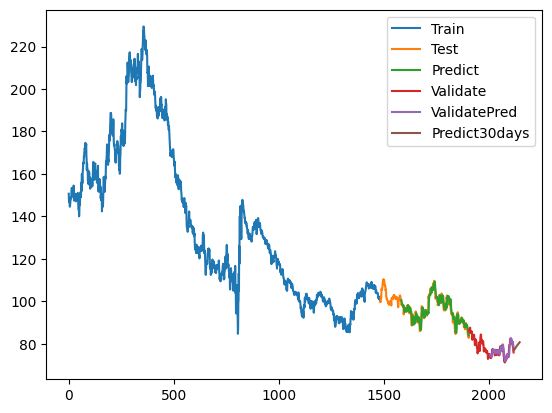

In [42]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [43]:
scaler.inverse_transform(lst_output)

array([[76.74291897],
       [76.77885089],
       [76.92431988],
       [77.08991982],
       [77.25553864],
       [77.41740417],
       [77.57538727],
       [77.7299703 ],
       [77.88162617],
       [78.03072108],
       [78.17753689],
       [78.32228825],
       [78.46515323],
       [78.60626215],
       [78.74573237],
       [78.88365055],
       [79.02010104],
       [79.15515045],
       [79.28885186],
       [79.42125776],
       [79.55241413],
       [79.68235812],
       [79.811121  ],
       [79.93873872],
       [80.06523606],
       [80.19064014],
       [80.31497042],
       [80.43825107],
       [80.56050156],
       [80.68173722]])